In [1]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
import math
import hamiltorch
import torch.distributions as dist
import seaborn as sns

In [2]:
torch.manual_seed(42)

In [3]:
model = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, 1)
)

In [4]:
# find total number of parameters in model
num_params = 0
for param in model.parameters():
    num_params += param.numel()
print(f"Total number of parameters in model: {num_params}")

Total number of parameters in model: 33


In [5]:
X, y = make_circles(n_samples=100, noise=0.02, random_state=42)

In [6]:
X = torch.from_numpy(X.astype(np.float32))
y = torch.from_numpy(y.astype(np.float32))

In [7]:
def negative_log_likelihood(parameters):
    params_list = hamiltorch.util.unflatten(model, parameters)
    w1, b1, w2, b2 = params_list
    res=0
    for i in range(len(X)):
        logit = F.linear(X[i], w1, b1)
        logit = F.relu(logit)
        logit = F.linear(logit, w2, b2)
        res+=torch.distributions.Bernoulli(logits=logit).log_prob(y[i])
    return -res

def negative_log_prior (parameters):
    normal_dist = dist.Normal(0, 1)
    return -normal_dist.log_prob(parameters).sum()

def negative_log_joint(parameters):
    return negative_log_likelihood(parameters) + negative_log_prior(parameters)

In [8]:
def log_prob(parameters):
    return -1*negative_log_joint(parameters)

In [9]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for i in range(2000):
    optimizer.zero_grad()
    loss = negative_log_joint(hamiltorch.util.flatten(model))
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'Epoch {i}, loss {loss.item()}')

Epoch 0, loss 102.09347534179688
Epoch 100, loss 99.25257873535156
Epoch 200, loss 98.80854797363281
Epoch 300, loss 98.36520385742188
Epoch 400, loss 97.96770477294922
Epoch 500, loss 97.6666259765625
Epoch 600, loss 97.58399200439453
Epoch 700, loss 97.55755615234375
Epoch 800, loss 97.54472351074219
Epoch 900, loss 97.5451889038086
Epoch 1000, loss 97.54696655273438
Epoch 1100, loss 97.5435791015625
Epoch 1200, loss 97.546875
Epoch 1300, loss 97.54403686523438
Epoch 1400, loss 97.54995727539062
Epoch 1500, loss 97.54505920410156
Epoch 1600, loss 97.54447937011719
Epoch 1700, loss 97.54436492919922
Epoch 1800, loss 97.54536437988281
Epoch 1900, loss 97.54329681396484


/opt/homebrew/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


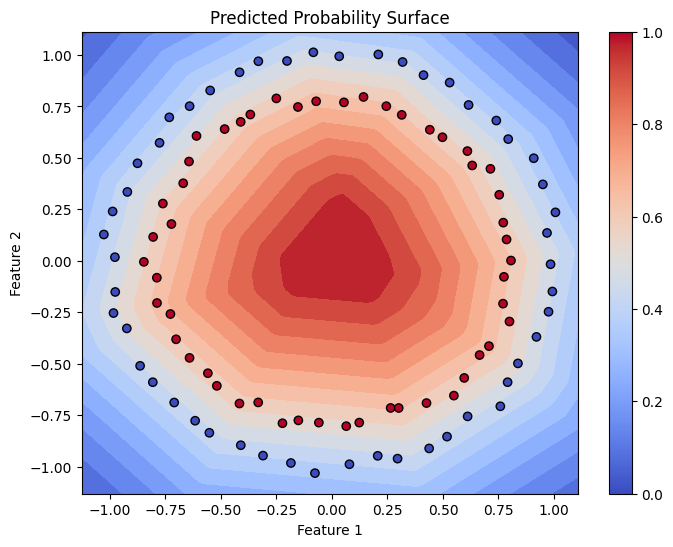

In [10]:
from matplotlib import pyplot as plt
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

x_range = torch.linspace(x_min, x_max, 100)
y_range = torch.linspace(y_min, y_max, 100)
xx, yy = torch.meshgrid(x_range, y_range)
grid_points = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=1)

# Calculate predicted probability surface using MAP estimate
with torch.no_grad():
    logits = model(grid_points)
    predicted_prob = torch.sigmoid(logits).reshape(xx.shape).numpy()

# Plot the predicted probability surface
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, predicted_prob, levels=20, cmap='coolwarm')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k', linewidths=1)
plt.title('Predicted Probability Surface')
plt.colorbar()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [11]:
from torch.autograd.functional import hessian

In [12]:
input = hamiltorch.util.flatten(model)
hessian_matrix = hessian(negative_log_joint, input)
hessian_matrix

tensor([[ 5.0687e+00,  5.7393e-01,  8.8783e-01,  ...,  0.0000e+00,
         -3.4865e-03, -4.6422e+00],
        [ 5.7393e-01,  5.0467e+00,  4.9164e-01,  ...,  0.0000e+00,
          2.0759e-03, -4.6650e+00],
        [ 8.8783e-01,  4.9164e-01,  4.9710e+00,  ...,  0.0000e+00,
          7.5562e-01,  3.2049e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-3.4865e-03,  2.0759e-03,  7.5562e-01,  ...,  0.0000e+00,
          4.7415e+00,  5.9206e+00],
        [-4.6422e+00, -4.6650e+00,  3.2049e+00,  ...,  0.0000e+00,
          5.9206e+00,  2.5585e+01]])

In [13]:
# invert the output matrix
covariance = torch.inverse(hessian_matrix)
covariance

tensor([[ 1.5791,  1.2062,  0.1563,  ..., -0.0000,  0.4567,  0.0223],
        [ 1.2062,  2.1547,  0.3640,  ...,  0.0000,  0.8043, -0.0206],
        [ 0.1563,  0.3640,  1.2891,  ...,  0.0000,  0.3462, -0.1435],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.4567,  0.8043,  0.3462,  ...,  0.0000,  2.0197, -0.2707],
        [ 0.0223, -0.0206, -0.1435,  ...,  0.0000, -0.2707,  0.7264]])

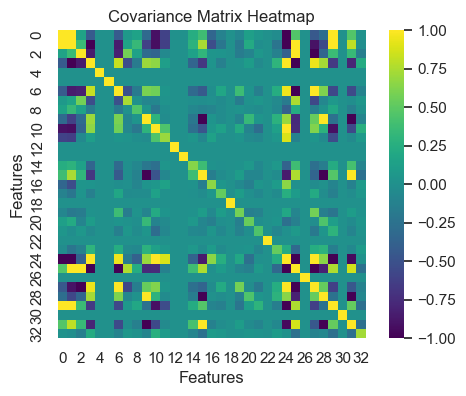

In [14]:
# Create a heatmap using Seaborn with a different colormap (e.g., "viridis")
sns.set()
plt.figure(figsize=(6, 4))
sns.heatmap(covariance, cmap="viridis", square=True, vmin=-1, vmax=1)  # Adjust vmin and vmax as needed

# Customize the plot (optional)
plt.title("Covariance Matrix Heatmap")
plt.xlabel("Features")
plt.ylabel("Features")

# Display the heatmap
plt.show()

In [15]:
diagonal_hessian_matrix = torch.zeros_like(hessian_matrix)
for i in range(hessian_matrix.shape[0]):
    for j in range(hessian_matrix.shape[1]):
        if i == j:
            diagonal_hessian_matrix[i, j] = hessian_matrix[i, j]
        else:
            diagonal_hessian_matrix[i, j] = 0
diagonal_hessian_matrix

tensor([[ 5.0687,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  5.0467,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  4.9710,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  4.7415,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, 25.5847]])

In [16]:
diagonal_covariance = torch.inverse(diagonal_hessian_matrix)
diagonal_covariance

tensor([[0.1973, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1981, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2012,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2109, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0391]])

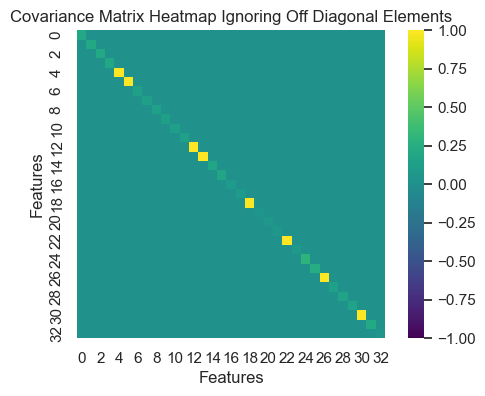

In [17]:
# Create a heatmap using Seaborn with a different colormap (e.g., "viridis")
sns.set()
plt.figure(figsize=(6, 4))
sns.heatmap(diagonal_covariance, cmap="viridis", square=True, vmin=-1, vmax=1)  # Adjust vmin and vmax as needed

# Customize the plot (optional)
plt.title("Covariance Matrix Heatmap Ignoring Off Diagonal Elements")
plt.xlabel("Features")
plt.ylabel("Features")

# Display the heatmap
plt.show()

In [18]:
parameters = hamiltorch.util.flatten(model)

In [19]:
# HMC
hamiltorch.set_random_seed(123)
params_init = torch.randn_like(parameters)
params_hmc = hamiltorch.sample(log_prob_func=log_prob, params_init=parameters, num_samples=1000,
                               step_size=0.1, num_steps_per_sample=10)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:01:42 | 0d:00:00:00 | #################### | 1000/1000 | 9.74        
Acceptance Rate 0.57


In [20]:
coords_hmc = torch.cat(params_hmc).reshape(len(params_hmc),-1).numpy()
samples = coords_hmc[100:]
samples.shape

(900, 33)

In [21]:
def prediction(x):
    array = []
    for parameter in samples:
        params_list = hamiltorch.util.unflatten(model, torch.tensor(parameter))
        w1, b1, w2, b2 = params_list
        logit = F.linear(x, w1, b1)
        logit = F.relu(logit)
        logit = F.linear(logit, w2, b2)
        array.append(torch.sigmoid(logit).item())
    return np.mean(array), np.std(array)

In [22]:
prediction(torch.tensor([10.0,1.0]))

(0.0147006761893118, 0.10308398769875338)

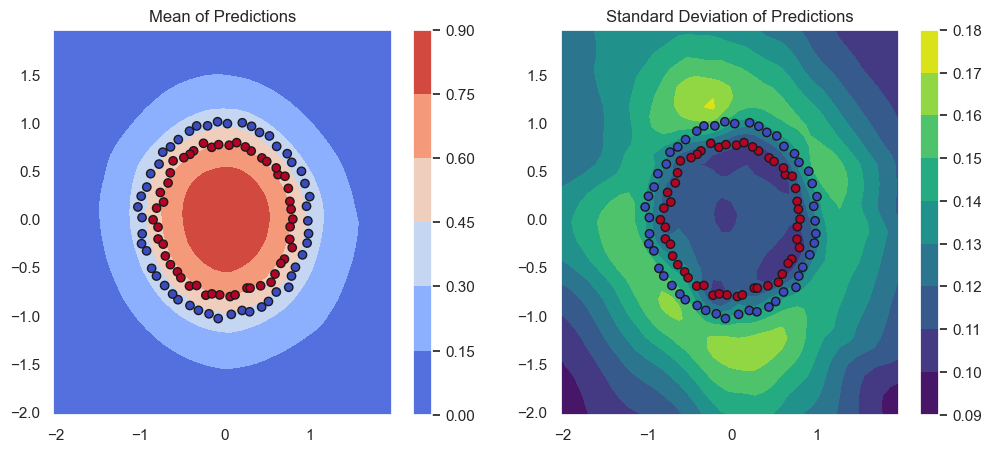

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of x and y values for the grid
x_min, x_max = min(X[:, 0]) - 1, max(X[:, 0]) + 1
y_min, y_max = min(X[:, 1]) - 1, max(X[:, 1]) + 1

# Generate a grid of points
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Initialize arrays to store mean and std values
mean_values = np.zeros_like(xx)
std_values = np.zeros_like(xx)

# Calculate mean and std for each point on the grid
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        x_point = np.array([xx[i, j], yy[i, j]])
        mean, std = prediction(torch.from_numpy(x_point).float())
        mean_values[i, j] = mean
        std_values[i, j] = std

# Create a figure with subplots for mean and std
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the mean colormap
cmap_mean = ax1.contourf(xx, yy, mean_values, cmap='coolwarm')
ax1.set_title('Mean of Predictions')
ax1.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k', linewidths=1)

# Plot the std colormap
cmap_std = ax2.contourf(xx, yy, std_values, cmap='viridis')
ax2.set_title('Standard Deviation of Predictions')
ax2.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k', linewidths=1)

# Add colorbars
fig.colorbar(cmap_mean, ax=ax1)
fig.colorbar(cmap_std, ax=ax2)

# Show the plot
plt.show()